In [1]:
import numpy as np
import pandas as pd
import string
import spacy
import math
import re
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model
import tensorflow as tf
from  matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\guill\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv("C:/Users/guill/Documents/ML_NOAC_NOVA_Extraction_Cleaned.csv")
data.head()

,CaseNumber,Type,Topics,TeamName,RequesterEmail,EmailObject,LastEmailCCAddress,AttributesURL,ContactAttributesURL,ContactEmail,LastIncomingEmailContent,LastEmailCCAddressCount
0,100124562,0,T039,US-NOR-CMA-BKG-PREFERRED,NaN,NAM4999926A,op@easywayintl.com,5005p00002evRjHAAU,0035p00003aZAdZAAW,usa.wcportops@cma-cgm.com,\n\n\nThank you Jessica! Await your further on...,1
1,100080371,0,T036,US-BNA-CMA-CS-IMP-DIVERSIONS,NaN,MOGELIJKE COD'S F119086 // RTM,janneke.van.leeuwen@fclmarine.nl; executivedes...,5005p00002evWsuAAE,0030N00003N771RQAR,janneke.van.leeuwen@fclmarine.nl,"\nHi Nese,\n \nInmiddels de aangepaste bl’s al...",5
2,100095395,0,T035,US-NOR-CMA-BKG-PREFERRED,tina@generallogistics.net,AMEND NAM5088900 [ ref:_00D,bookings@generallogistics.net,5005p00002evX4SAAU,0030N00002x1JqPQAU,tina@generallogistics.net,"\nHello,\nPlease SPLIT subject line booking to...",1
3,100097054,0,T847,US-NOR-CMA-BKG-SPECIALTY,bookings@delongcompany.com,FW: CMA CGM - Cut-off date cha,usa.cmaexportactive@usa.cma-cgm.com,5005p00002evXIsAAM,0030N00002tXvvIQAS,bookings@delongcompany.com,"CMA CGM - Cut-off date change at - NEW YORK, N...",1
4,100097055,0,T847,US-NOR-CMA-BKG-SPECIALTY,bookings@delongcompany.com,FW: CMA CGM - Cut-off date cha,NaN,5005p00002evXItAAM,0030N00002tXvvIQAS,bookings@delongcompany.com,"CMA CGM - Cut-off date change at - NEW YORK, N...",0


In [3]:
emails_train, emails_test, target_train, target_test = train_test_split(data["LastIncomingEmailContent"],data["Type"],test_size = 0.2) 

In [4]:
def to_lower(word):
    result = word.lower()
    return result

In [5]:
def remove_punctuation(word):
    result= word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

In [6]:
def remove_stop_words(words):
    result = [i for i in words if i not in ENGLISH_STOP_WORDS]
    return result

In [7]:
def remove_hyperlink(word):
    return re.sub(r"http\S+", "", word)

In [8]:
def replace_newline(word):
    return word.replace('\n','')

In [9]:
def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

In [10]:
def remove_whitespace(word):
    result = word.strip()
    return result

In [11]:
def introduce_empty(word):
    if not word or not isinstance(word, str) or len(word) == 0:
        return "[EMPTY]"
    return word

In [12]:
def clean_up_pipeline(sentence):
    cleaning_utils = [introduce_empty,
                      remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,
                      remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

In [13]:
x_train = [clean_up_pipeline(o) for o in tqdm(emails_train)]

100%|██████████| 200987/200987 [00:43<00:00, 4673.04it/s]


In [14]:
x_test = [clean_up_pipeline(o) for o in tqdm(emails_test)]

100%|██████████| 50247/50247 [00:10<00:00, 4699.46it/s]


In [15]:
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

In [16]:
## some config values 
embed_size = 100 # how big is each word vector
max_feature = 25000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 500 # max number of words in a question to use

In [17]:
tokenizer = Tokenizer(num_words=max_feature)
tokenizer.fit_on_texts(x_train)
x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

C:\Users\guill\AppData\Local\Temp\ipykernel_64576\904228051.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
C:\Users\guill\AppData\Local\Temp\ipykernel_64576\904228051.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test_features = np.array(tokenizer.texts_to_sequences(x_test))


In [18]:
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)

In [19]:
#size of the output vector from each layer
embedding_vector_length = 32
#Creating a sequential model
model = tf.keras.Sequential()
#Creating an embedding layer to vectorize
model.add(Embedding(max_feature, embedding_vector_length, input_length=max_len))
#Addding Bi-directional LSTM
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
#Relu allows converging quickly and allows backpropagation
model.add(Dense(16, activation='relu'))
#Deep Learninng models can be overfit easily, to avoid this, we add randomization using drop out
model.add(Dropout(0.1))
#Adding sigmoid activation function to normalize the output
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Precision()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           800000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 851,745
Trainable params: 851,745
Non-trainable params: 0
__________________________________________________

In [20]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) #print no of GPU device

Num GPUs Available:  1


In [21]:
history = model.fit(x_train_features, train_y, batch_size=512, epochs=20, validation_data=(x_test_features, test_y))

Epoch 1/20
393/393 [==============================] - 49s 114ms/step - loss: 0.5007 - precision: 0.6293 - val_loss: 0.4860 - val_precision: 0.8959
Epoch 2/20
393/393 [==============================] - 43s 109ms/step - loss: 0.4378 - precision: 0.6849 - val_loss: 0.4293 - val_precision: 0.6464
Epoch 3/20
393/393 [==============================] - 49s 124ms/step - loss: 0.4016 - precision: 0.7071 - val_loss: 0.4180 - val_precision: 0.6851
Epoch 4/20
393/393 [==============================] - 47s 119ms/step - loss: 0.3784 - precision: 0.7275 - val_loss: 0.4065 - val_precision: 0.7036
Epoch 5/20
393/393 [==============================] - 55s 140ms/step - loss: 0.3580 - precision: 0.7421 - val_loss: 0.4068 - val_precision: 0.7120
Epoch 6/20
393/393 [==============================] - 61s 155ms/step - loss: 0.3552 - precision: 0.7530 - val_loss: 0.4270 - val_precision: 0.7605
Epoch 7/20
393/393 [==============================] - 65s 166ms/step - loss: 0.3450 - precision: 0.7631 - val_loss: 0.

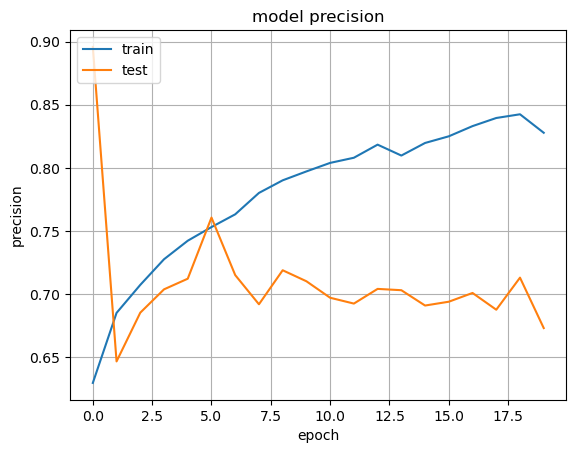

In [22]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [23]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

1571/1571 [==============================] - 44s 28ms/step


In [24]:
cf_matrix =confusion_matrix(test_y,y_predict)

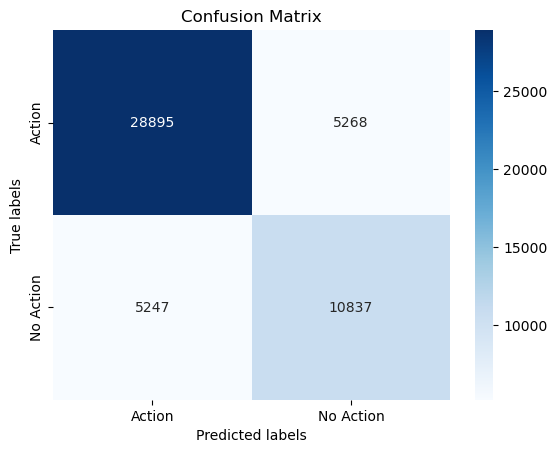

In [25]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Action', 'No Action']); ax.yaxis.set_ticklabels(['Action', 'No Action']);

In [26]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 67.29%
Recall: 67.38%
F1 Score: 67.33%


In [27]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
